In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile, assemble
from qiskit.visualization import array_to_latex

We will first create a simple noise model, which randomly flips each bit in an output with probability p.

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

Let's start with an instance of this in which each bit is flipped 1%of the time.

In [3]:
noise_model = get_noise(0.01)

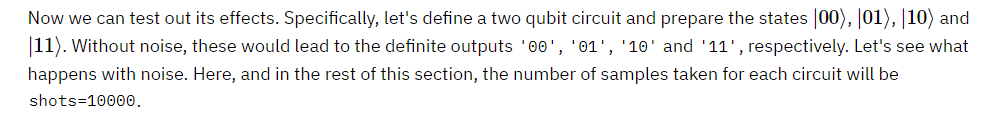

In [5]:
aer_sim = Aer.get_backend('aer_simulator')
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    print(state+' becomes', counts)

00 becomes {'00': 9815, '10': 90, '01': 92, '11': 3}
01 becomes {'01': 9797, '00': 107, '11': 96}
10 becomes {'10': 9790, '00': 114, '11': 95, '01': 1}
11 becomes {'10': 110, '11': 9784, '01': 105, '00': 1}


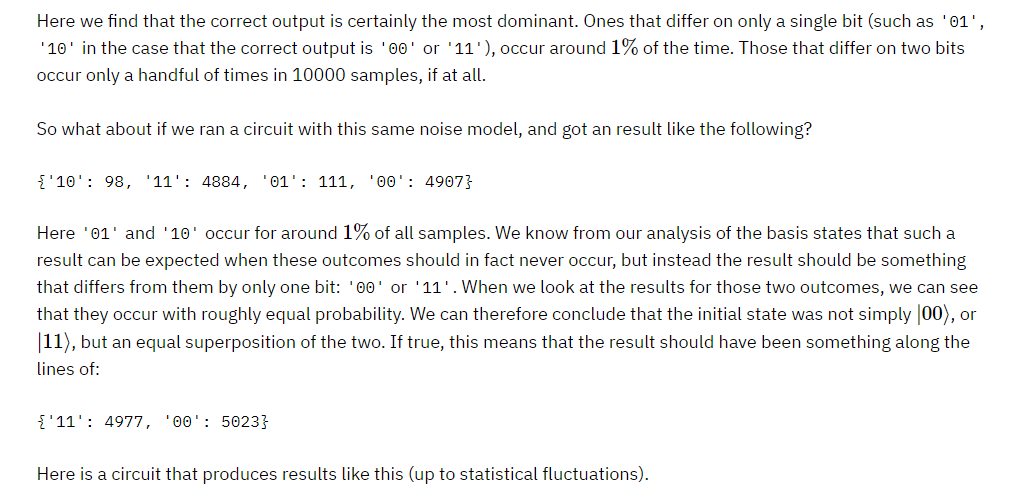

In [6]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
print(counts)

{'00': 4907, '11': 4889, '01': 109, '10': 95}


In this example we first looked at results for each of the definite basis states, and used these results to mitigate the effects of errors for a more general form of state. This is the basic principle behind measurement error mitigation.

# Error Mitigation in Qiskit

In [7]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

The process of measurement error mitigation can also be done using tools from Qiskit. This handles the collection of data for the basis states, the construction of the matrices and the calculation of the inverse. The latter can be done using the pseudo inverse, as we saw above. However, the default is an even more sophisticated method using least squares fitting.

As an example, let's stick with doing error mitigation for a pair of qubits. For this we define a two qubit quantum register, and feed it into the function complete_meas_cal.

In [8]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

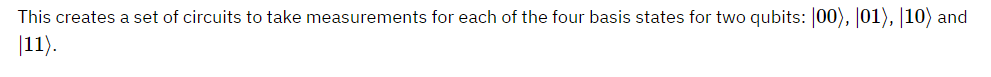

In [9]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
        ░ ┌─┐   
q69_0: ─░─┤M├───
        ░ └╥┘┌─┐
q69_1: ─░──╫─┤M├
        ░  ║ └╥┘
 c0: 2/════╩══╩═
           0  1 

Circuit mcalcal_01
       ┌───┐ ░ ┌─┐   
q69_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
q69_1: ──────░──╫─┤M├
             ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_10
             ░ ┌─┐   
q69_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
q69_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 

Circuit mcalcal_11
       ┌───┐ ░ ┌─┐   
q69_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
q69_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
 c0: 2/═════════╩══╩═
                0  1 



Let's now run these circuits without any noise present.

In [10]:
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, shots=10000).result()

With the results we can construct the calibration matrix, which we have been calling M.

In [11]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

With no noise present, this is simply the identity matrix.

Now let's create a noise model. And to make things interesting, let's have the errors be ten times more likely than before.

In [12]:
noise_model = get_noise(0.1)

Again we can run the circuits, and look at the calibration matrix, M.

In [17]:
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

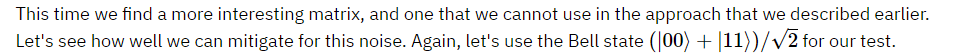

In [18]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'01': 935, '11': 4072, '00': 4043, '10': 950}


In Qiskit we mitigate for the noise by creating a measurement filter object. Then, taking the results from above, we use this to calculate a mitigated set of counts. Qiskit returns this as a dictionary, so that the user doesn't need to use vectors themselves to get the result.

In [19]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

To see the results most clearly, let's plot both the noisy and mitigated results.

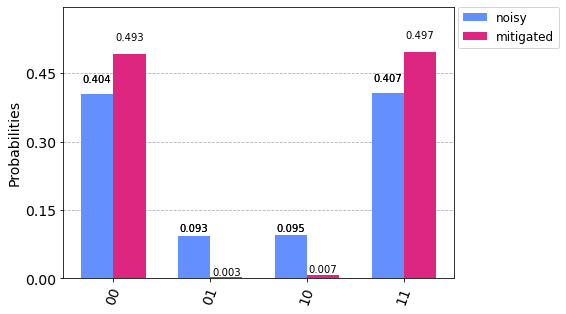

In [21]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

Here we have taken results for which almost 20% of samples are in the wrong state, and turned it into an exact representation of what the true results should be. However, this example does have just two qubits with a simple noise model. For more qubits, and more complex noise models or data from real devices, the mitigation will have more of a challenge. Perhaps you might find methods that are better than those Qiskit uses!